#Supervised Contrastive Learning

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Implementation by G. M. Shahariar Shibli

#Version and GPU check

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
!nvidia-smi

Sun Apr 30 11:00:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Installation

In [ ]:
%%capture
!pip3 install tensorflow-addons
!pip3 install tf_keras_vis

#Imports

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras

import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import datetime
import glob
import os

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Configurations

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
CROP_TO = 224

num_classes = 23
input_shape = (224, 224, 3)

LR = 2e-5
shuffler = 1024

#Data Augmentation

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image, label):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image, label

# Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cecum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/cecum/*.*')
ileum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ileum/*.*')
retroflex_rectum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_rectum/*.*')
hemorrhoids = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/hemorrhoids/*.*')
polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/polyps/*.*')
ulcerative_colitis_grade_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-0-1/*.*')
ulcerative_colitis_grade_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1/*.*')
ulcerative_colitis_grade_1_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1-2/*.*')
ulcerative_colitis_grade_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2/*.*')
ulcerative_colitis_grade_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2-3/*.*')
ulcerative_colitis_grade_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-3/*.*')
bbps_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-0-1/*.*')
bbps_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-2-3/*.*')
impacted_stool = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/impacted-stool/*.*')
dyed_lifted_polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-lifted-polyps/*.*')
dyed_resection_margins = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-resection-margins/*.*')
pylorus = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/pylorus/*.*')
retroflex_stomach = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_stomach/*.*')
z_line = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/z_line/*.*')
barretts = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts/*.*')
barretts_short_segment = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts-short-segment/*.*')
esophagitis_a = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-a/*.*')
esophagitis_b_d = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-b-d/*.*')

In [ ]:
#dataset = {0: cecum, 1:pylorus, 2:retroflex_rectum, 3:retroflex_stomach, 4:z_line}
dataset = {0 :cecum, 1:ileum, 2:retroflex_rectum, 3:hemorrhoids, 4:polyps,5:ulcerative_colitis_grade_0_1,6:ulcerative_colitis_grade_1,7:ulcerative_colitis_grade_1_2,8:ulcerative_colitis_grade_2,9:ulcerative_colitis_grade_2_3,10:ulcerative_colitis_grade_3,11:bbps_0_1 ,12:bbps_2_3,13:impacted_stool,14:dyed_lifted_polyps,15:dyed_resection_margins,16:pylorus,17:retroflex_stomach,18:z_line,19:barretts,20:barretts_short_segment,21:esophagitis_a ,22:esophagitis_b_d }

In [ ]:
def combineDataAndLabel(width, height, dataset):

  data = []
  labels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
          target_size= (width,height))
          image=np.array(image)
          data.append(image)
          count=count+1
          labels.append(cls)
      print(f"\n\processed {count} images \n\n")


  # for i in cecum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(0)

  # for i in ileum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(1)
  # for i in pylorus:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(2)
  # for i in retroflex_rectum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(3)
  # for i in retroflex_stomach:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(4)
  # for i in z_line:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(5)

  data = np.array(data)
  labels = np.array(labels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ML/combinedData_224', data)
  np.save('/content/drive/MyDrive/ML/combinedLabels_224', labels)
  print(f"\n\nSaved")

  return data, labels


In [ ]:
import os
data = []
labels = []
if(os.path.isfile("/content/drive/MyDrive/ML/combinedData_224.npy") and os.path.isfile("/content/drive/MyDrive/ML/combinedLabels_224.npy")):
  data = np.load("/content/drive/MyDrive/ML/combinedData_224.npy")
  labels = np.load("/content/drive/MyDrive/ML/combinedLabels_224.npy")
else:
  data, labels = combineDataAndLabel(224,224,dataset)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42,stratify = labels)

In [ ]:
# Load data
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (8529, 224, 224, 3) - y_train shape: (8529,)
x_test shape: (2133, 224, 224, 3) - y_test shape: (2133,)


In [ ]:
#contrastive training
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds.shuffle(shuffler).map(custom_augment).batch(BATCH_SIZE))

#cross-entropy training
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffler).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffler).batch(BATCH_SIZE)

#Contrastive Loss Functions

Max Margin Loss, N pairs loss, Triplet loss, NT-XENT loss

In [ ]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


#def square_to_vec(D):
   #'''Convert a squared form pdist matrix to vector form.
    #'''
 #   n = D.shape[0]
  #  triu_idx = np.triu_indices(n, k=1)
   # d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    #return d_vec
def square_to_vec(D):
    with tf.name_scope("square_to_vec"):
        n = D.shape[0]
        triu_idx = np.triu_indices(n, k=1)
        triu_idx_int = np.array(triu_idx).astype(np.int32)
        d_vec = tf.gather_nd(D, list(zip(triu_idx_int[0], triu_idx_int[1])))
        return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss.
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from:
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

#Encoder with Contrastive Learning

In [ ]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [ ]:
# Encoder Architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.EfficientNetV2B2(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True
    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    normalized_embed = UnitNormLayer()(projection_3)

    resnet_simclr = Model(base_model.inputs, normalized_embed)

    return resnet_simclr

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_resnet_simclr(512, 256, 128)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']      

In [ ]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in test_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    train_loss_dict[epoch] = train_loss_cl.result().numpy()*100
    test_loss_dict[epoch] = test_loss_cl.result().numpy()*100

100%|██████████| 134/134 [02:29<00:00,  1.11s/it]


Epoch 1, Training Loss: 0.07870976626873016, Test Loss: 0.1230342835187912


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 2, Training Loss: 0.07547639310359955, Test Loss: 0.09350120276212692


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 3, Training Loss: 0.07461166381835938, Test Loss: 0.08500467985868454


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 4, Training Loss: 0.07300758361816406, Test Loss: 0.07679552584886551


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 5, Training Loss: 0.07157726585865021, Test Loss: 0.07470492273569107


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 6, Training Loss: 0.06966963410377502, Test Loss: 0.07383996248245239


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 7, Training Loss: 0.06834666430950165, Test Loss: 0.07245618104934692


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 8, Training Loss: 0.06680571287870407, Test Loss: 0.07196974754333496


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 9, Training Loss: 0.0670141726732254, Test Loss: 0.06717925518751144


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 10, Training Loss: 0.06494150310754776, Test Loss: 0.0671740248799324


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 11, Training Loss: 0.06503712385892868, Test Loss: 0.0642099380493164


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 12, Training Loss: 0.0640619546175003, Test Loss: 0.06382235139608383


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 13, Training Loss: 0.062351275235414505, Test Loss: 0.06120239198207855


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 14, Training Loss: 0.062486376613378525, Test Loss: 0.06163094937801361


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 15, Training Loss: 0.06275633722543716, Test Loss: 0.061291176825761795


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 16, Training Loss: 0.06165813282132149, Test Loss: 0.05889767035841942


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 17, Training Loss: 0.06112000346183777, Test Loss: 0.05784013494849205


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 18, Training Loss: 0.06114758178591728, Test Loss: 0.057120129466056824


100%|██████████| 134/134 [01:21<00:00,  1.63it/s]


Epoch 19, Training Loss: 0.06074044108390808, Test Loss: 0.05888744816184044


100%|██████████| 134/134 [01:07<00:00,  1.97it/s]


Epoch 20, Training Loss: 0.0585503987967968, Test Loss: 0.057074449956417084


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 21, Training Loss: 0.05924474820494652, Test Loss: 0.05649281293153763


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 22, Training Loss: 0.059005554765462875, Test Loss: 0.054859526455402374


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 23, Training Loss: 0.05863295495510101, Test Loss: 0.053377050906419754


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 24, Training Loss: 0.058404576033353806, Test Loss: 0.056279998272657394


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 25, Training Loss: 0.05830005183815956, Test Loss: 0.054342661052942276


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 26, Training Loss: 0.057594191282987595, Test Loss: 0.05207126587629318


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 27, Training Loss: 0.05814092233777046, Test Loss: 0.052067194133996964


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 28, Training Loss: 0.05698724091053009, Test Loss: 0.04892459139227867


100%|██████████| 134/134 [01:21<00:00,  1.63it/s]


Epoch 29, Training Loss: 0.05620203912258148, Test Loss: 0.04900841787457466


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 30, Training Loss: 0.056617144495248795, Test Loss: 0.05008302256464958


100%|██████████| 134/134 [01:07<00:00,  1.99it/s]


Epoch 31, Training Loss: 0.05544137954711914, Test Loss: 0.048238255083560944


100%|██████████| 134/134 [01:07<00:00,  1.99it/s]


Epoch 32, Training Loss: 0.055532462894916534, Test Loss: 0.046734146773815155


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 33, Training Loss: 0.05496610328555107, Test Loss: 0.04791918396949768


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 34, Training Loss: 0.053614936769008636, Test Loss: 0.045502688735723495


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 35, Training Loss: 0.05349484458565712, Test Loss: 0.04667578637599945


100%|██████████| 134/134 [01:07<00:00,  1.99it/s]


Epoch 36, Training Loss: 0.052998270839452744, Test Loss: 0.046214163303375244


100%|██████████| 134/134 [01:07<00:00,  1.99it/s]


Epoch 37, Training Loss: 0.05265349894762039, Test Loss: 0.045107487589120865


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 38, Training Loss: 0.051837459206581116, Test Loss: 0.04329243302345276


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 39, Training Loss: 0.052361924201250076, Test Loss: 0.04405870661139488


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 40, Training Loss: 0.05123591795563698, Test Loss: 0.04364163056015968


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 41, Training Loss: 0.05143727734684944, Test Loss: 0.044312480837106705


100%|██████████| 134/134 [01:21<00:00,  1.63it/s]


Epoch 42, Training Loss: 0.05036604404449463, Test Loss: 0.04202334210276604


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 43, Training Loss: 0.050865739583969116, Test Loss: 0.04063756763935089


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 44, Training Loss: 0.049688007682561874, Test Loss: 0.042229585349559784


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 45, Training Loss: 0.05044019594788551, Test Loss: 0.03965979069471359


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 46, Training Loss: 0.049189988523721695, Test Loss: 0.03895688056945801


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 47, Training Loss: 0.04915600270032883, Test Loss: 0.03980080410838127


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 48, Training Loss: 0.04916607588529587, Test Loss: 0.03924410790205002


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 49, Training Loss: 0.048671331256628036, Test Loss: 0.04022803157567978


100%|██████████| 134/134 [01:07<00:00,  1.98it/s]


Epoch 50, Training Loss: 0.047845810651779175, Test Loss: 0.03910806030035019


In [ ]:
from pickle import load, dump
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_EfficientNetV2B2.pkl', 'wb') as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open('/content/drive/MyDrive/ML/test_loss_EfficientNetV2B2.pkl', 'wb') as file:
    dump(test_loss_dict, file)

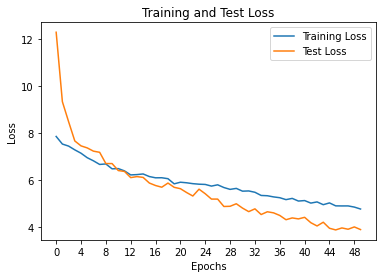

In [ ]:
# Load the training and validation loss dictionaries
train_loss = load(open('/content/drive/MyDrive/ML/train_loss_EfficientNetV2B2.pkl', 'rb'))
test_loss = load(open('/content/drive/MyDrive/ML/test_loss_EfficientNetV2B2.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
test_values = test_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(50)

# Plot and label the training and validation loss valuesa
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 50, 4))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filename =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "EfficientNetV2B2_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filename)

model.save_weights(filename)

/content/drive/MyDrive/Colab Notebooks/20230308-145921EfficientNetV2B2_simclr.h5


#Classifier with frozen Encoder

In [ ]:
new_model = get_resnet_simclr(512, 256, 128)
new_model.load_weights("/content/drive/MyDrive/Colab Notebooks/20230308-145921EfficientNetV2B2_simclr.h5")

In [ ]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
def Classifier_Network():
    '''For stage 2, simply a softmax on top of the Encoder.
    '''
    contrast_model = new_model
    contrast_model.trainable = False
    embedd = contrast_model.output
    features = Dropout(0.5)(embedd)
    features = Dense(64, activation="relu")(features)
    features = Dropout(0.5)(features)
    outputs  = Dense(num_classes, activation="softmax")(features)

    classifier_model = Model(contrast_model.inputs, outputs)

    return classifier_model

In [ ]:
classifier = Classifier_Network()

In [ ]:
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  0          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [ ]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
sample_weight = tf.random.uniform((tf.shape(y_train)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
sample_weight

<tf.Tensor: shape=(8529, 1), dtype=float32, numpy=
array([[0.7861433 ],
       [0.49920297],
       [0.29927063],
       ...,
       [0.05716491],
       [0.14451802],
       [0.6533736 ]], dtype=float32)>

In [ ]:
@tf.function
# train step for the 2nd stage
def train_step(x, y,sample_weight):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_preds = classifier(x, training=True)
        loss = cce_loss_obj(y, y_preds,sample_weight = sample_weight)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss,
                              classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(gradients,
                                  classifier.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [ ]:
@tf.function
def test_step(x, y):
    y_preds = classifier(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
#classifier training
train_loss_dict_classifier = {}
test_loss_dict_classifier = {}
train_acc_dict = {}
test_acc_dict = {}

for epoch in range(220):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()


    for x, y in tqdm(train_ds2):
        #print(x.shape,y.shape)
        sample_weight = tf.random.uniform((tf.shape(x)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
        train_step(x, y,sample_weight)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    template = 'Epoch {}, Train Loss: {}, Train Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,train_loss.result(), train_acc.result() * 100,test_loss.result(),test_acc.result() * 100))
    train_loss_dict_classifier[epoch] = train_loss.result().numpy()
    test_loss_dict_classifier[epoch] = test_loss.result().numpy()
    train_acc_dict[epoch] = train_acc.result().numpy()*100
    test_acc_dict[epoch] = test_acc.result().numpy()*100

100%|██████████| 134/134 [00:39<00:00,  3.38it/s]


Epoch 1, Train Loss: 1.5737024545669556, Train Acc: 3.7050063610076904, Test Loss: 3.1322879791259766, Test Acc: 3.6568212509155273


100%|██████████| 134/134 [00:16<00:00,  8.18it/s]


Epoch 2, Train Loss: 1.565688133239746, Train Acc: 4.455387592315674, Test Loss: 3.1082842350006104, Test Acc: 4.031879901885986


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 3, Train Loss: 1.5550270080566406, Train Acc: 5.698206424713135, Test Loss: 3.084707021713257, Test Acc: 15.564931869506836


100%|██████████| 134/134 [00:17<00:00,  7.88it/s]


Epoch 4, Train Loss: 1.5514482259750366, Train Acc: 7.538984775543213, Test Loss: 3.0608248710632324, Test Acc: 17.909048080444336


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 5, Train Loss: 1.5248908996582031, Train Acc: 9.133544921875, Test Loss: 3.036980152130127, Test Acc: 23.722455978393555


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 6, Train Loss: 1.5161702632904053, Train Acc: 12.193692207336426, Test Loss: 3.0120630264282227, Test Acc: 29.535865783691406


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 7, Train Loss: 1.5043954849243164, Train Acc: 13.82342529296875, Test Loss: 2.983287811279297, Test Acc: 33.005157470703125


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 8, Train Loss: 1.498367190361023, Train Acc: 17.28221321105957, Test Loss: 2.956897258758545, Test Acc: 36.66197967529297


100%|██████████| 134/134 [00:16<00:00,  7.88it/s]


Epoch 9, Train Loss: 1.4810117483139038, Train Acc: 19.509906768798828, Test Loss: 2.924325704574585, Test Acc: 40.646976470947266


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 10, Train Loss: 1.4841808080673218, Train Acc: 21.456209182739258, Test Loss: 2.892932176589966, Test Acc: 53.02391052246094


100%|██████████| 134/134 [00:17<00:00,  7.87it/s]


Epoch 11, Train Loss: 1.4479368925094604, Train Acc: 24.01219367980957, Test Loss: 2.8593952655792236, Test Acc: 60.52508544921875


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 12, Train Loss: 1.4450312852859497, Train Acc: 27.28338623046875, Test Loss: 2.824634552001953, Test Acc: 62.869197845458984


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 13, Train Loss: 1.431388258934021, Train Acc: 28.65517807006836, Test Loss: 2.7885642051696777, Test Acc: 63.3380241394043


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 14, Train Loss: 1.4190609455108643, Train Acc: 30.777347564697266, Test Loss: 2.7527477741241455, Test Acc: 63.3380241394043


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 15, Train Loss: 1.4097200632095337, Train Acc: 33.110565185546875, Test Loss: 2.710564613342285, Test Acc: 62.353492736816406


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 16, Train Loss: 1.3716504573822021, Train Acc: 34.576148986816406, Test Loss: 2.6734259128570557, Test Acc: 61.275203704833984


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 17, Train Loss: 1.3630717992782593, Train Acc: 36.38175582885742, Test Loss: 2.6299893856048584, Test Acc: 60.8532600402832


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 18, Train Loss: 1.3442586660385132, Train Acc: 37.53077697753906, Test Loss: 2.5915346145629883, Test Acc: 60.61884689331055


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 19, Train Loss: 1.330417513847351, Train Acc: 38.63290023803711, Test Loss: 2.5501949787139893, Test Acc: 60.43132019042969


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 20, Train Loss: 1.3106231689453125, Train Acc: 41.04819107055664, Test Loss: 2.5061914920806885, Test Acc: 60.19690704345703


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 21, Train Loss: 1.2778632640838623, Train Acc: 42.0447883605957, Test Loss: 2.4640979766845703, Test Acc: 60.10314178466797


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 22, Train Loss: 1.2757340669631958, Train Acc: 42.900691986083984, Test Loss: 2.422609567642212, Test Acc: 60.2437858581543


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 23, Train Loss: 1.26592218875885, Train Acc: 43.41657638549805, Test Loss: 2.3814899921417236, Test Acc: 60.290672302246094


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 24, Train Loss: 1.2329792976379395, Train Acc: 44.893890380859375, Test Loss: 2.3387341499328613, Test Acc: 60.47819900512695


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 25, Train Loss: 1.2240073680877686, Train Acc: 45.855316162109375, Test Loss: 2.3013265132904053, Test Acc: 60.47819900512695


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 26, Train Loss: 1.1898877620697021, Train Acc: 46.00773620605469, Test Loss: 2.2613043785095215, Test Acc: 60.80637741088867


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 27, Train Loss: 1.1977492570877075, Train Acc: 46.629150390625, Test Loss: 2.2202887535095215, Test Acc: 61.134552001953125


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 28, Train Loss: 1.1626216173171997, Train Acc: 47.97748947143555, Test Loss: 2.180243968963623, Test Acc: 61.50960922241211


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 29, Train Loss: 1.1444334983825684, Train Acc: 48.23543167114258, Test Loss: 2.1450746059417725, Test Acc: 61.50960922241211


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 30, Train Loss: 1.1383471488952637, Train Acc: 48.72787094116211, Test Loss: 2.1117961406707764, Test Acc: 61.60337448120117


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 31, Train Loss: 1.1057054996490479, Train Acc: 48.95063781738281, Test Loss: 2.071165084838867, Test Acc: 61.6502571105957


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 32, Train Loss: 1.1108876466751099, Train Acc: 50.2638053894043, Test Loss: 2.0353901386260986, Test Acc: 61.36896514892578


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 33, Train Loss: 1.0834790468215942, Train Acc: 50.17000961303711, Test Loss: 2.0007150173187256, Test Acc: 61.22831726074219


100%|██████████| 134/134 [00:16<00:00,  7.98it/s]


Epoch 34, Train Loss: 1.065379023551941, Train Acc: 50.252079010009766, Test Loss: 1.963391900062561, Test Acc: 61.22831726074219


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 35, Train Loss: 1.0623996257781982, Train Acc: 50.896942138671875, Test Loss: 1.9336680173873901, Test Acc: 61.22831726074219


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 36, Train Loss: 1.046677589416504, Train Acc: 51.377655029296875, Test Loss: 1.8987116813659668, Test Acc: 61.18143081665039


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 37, Train Loss: 1.0231853723526, Train Acc: 51.95216369628906, Test Loss: 1.871772050857544, Test Acc: 61.22831726074219


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 38, Train Loss: 1.0226138830184937, Train Acc: 51.9287109375, Test Loss: 1.8462659120559692, Test Acc: 61.36896514892578


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 39, Train Loss: 1.0069547891616821, Train Acc: 52.81978988647461, Test Loss: 1.8128033876419067, Test Acc: 61.556495666503906


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 40, Train Loss: 0.9787368774414062, Train Acc: 52.90186309814453, Test Loss: 1.7875641584396362, Test Acc: 61.60337448120117


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 41, Train Loss: 0.9837612509727478, Train Acc: 53.183258056640625, Test Loss: 1.7495311498641968, Test Acc: 61.60337448120117


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 42, Train Loss: 0.9625535607337952, Train Acc: 53.79294204711914, Test Loss: 1.7242087125778198, Test Acc: 61.6502571105957


100%|██████████| 134/134 [00:16<00:00,  7.89it/s]


Epoch 43, Train Loss: 0.9683670401573181, Train Acc: 53.91019058227539, Test Loss: 1.6996052265167236, Test Acc: 61.69713592529297


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 44, Train Loss: 0.9568628072738647, Train Acc: 54.67229461669922, Test Loss: 1.67632257938385, Test Acc: 61.83778762817383


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 45, Train Loss: 0.9465575814247131, Train Acc: 54.90679168701172, Test Loss: 1.656268835067749, Test Acc: 61.931549072265625


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 46, Train Loss: 0.9255983829498291, Train Acc: 54.625396728515625, Test Loss: 1.637528657913208, Test Acc: 62.02531433105469


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 47, Train Loss: 0.9118140935897827, Train Acc: 55.35232925415039, Test Loss: 1.6070280075073242, Test Acc: 62.072200775146484


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 48, Train Loss: 0.9189497232437134, Train Acc: 55.692344665527344, Test Loss: 1.5866343975067139, Test Acc: 62.02531433105469


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 49, Train Loss: 0.8904923796653748, Train Acc: 55.83304214477539, Test Loss: 1.567626714706421, Test Acc: 62.16596221923828


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 50, Train Loss: 0.8802810907363892, Train Acc: 55.42267608642578, Test Loss: 1.55130136013031, Test Acc: 62.259727478027344


100%|██████████| 134/134 [00:17<00:00,  7.88it/s]


Epoch 51, Train Loss: 0.8957405090332031, Train Acc: 55.762691497802734, Test Loss: 1.5252763032913208, Test Acc: 62.353492736816406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 52, Train Loss: 0.8566913604736328, Train Acc: 56.19650650024414, Test Loss: 1.5127651691436768, Test Acc: 62.4472541809082


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 53, Train Loss: 0.8530462384223938, Train Acc: 57.028961181640625, Test Loss: 1.4869822263717651, Test Acc: 62.494140625


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 54, Train Loss: 0.8548055291175842, Train Acc: 56.51306915283203, Test Loss: 1.4719384908676147, Test Acc: 62.541019439697266


100%|██████████| 134/134 [00:16<00:00,  7.89it/s]


Epoch 55, Train Loss: 0.8448067307472229, Train Acc: 57.028961181640625, Test Loss: 1.4572935104370117, Test Acc: 62.494140625


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 56, Train Loss: 0.8511986136436462, Train Acc: 57.01723861694336, Test Loss: 1.4437792301177979, Test Acc: 62.494140625


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 57, Train Loss: 0.8321573138237, Train Acc: 56.58342361450195, Test Loss: 1.4292947053909302, Test Acc: 62.58790588378906


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 58, Train Loss: 0.8353274464607239, Train Acc: 57.380699157714844, Test Loss: 1.4198038578033447, Test Acc: 62.68166732788086


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 59, Train Loss: 0.8189685940742493, Train Acc: 57.58002471923828, Test Loss: 1.3847469091415405, Test Acc: 62.63478469848633


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 60, Train Loss: 0.8138846158981323, Train Acc: 57.59174728393555, Test Loss: 1.3801153898239136, Test Acc: 62.68166732788086


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 61, Train Loss: 0.8039366602897644, Train Acc: 57.920040130615234, Test Loss: 1.3681100606918335, Test Acc: 62.82231903076172


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 62, Train Loss: 0.8015119433403015, Train Acc: 58.013832092285156, Test Loss: 1.3456411361694336, Test Acc: 62.96295928955078


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 63, Train Loss: 0.796484112739563, Train Acc: 58.1897087097168, Test Loss: 1.3293503522872925, Test Acc: 63.00984573364258


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 64, Train Loss: 0.7892717123031616, Train Acc: 58.74076461791992, Test Loss: 1.3259111642837524, Test Acc: 63.19737243652344


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 65, Train Loss: 0.7803581953048706, Train Acc: 58.095909118652344, Test Loss: 1.3135286569595337, Test Acc: 63.244258880615234


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 66, Train Loss: 0.7693936824798584, Train Acc: 58.52972412109375, Test Loss: 1.2914608716964722, Test Acc: 63.431785583496094


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 67, Train Loss: 0.7561975717544556, Train Acc: 58.6235237121582, Test Loss: 1.2875964641571045, Test Acc: 63.431785583496094


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 68, Train Loss: 0.77134108543396, Train Acc: 59.67874526977539, Test Loss: 1.267117977142334, Test Acc: 63.431785583496094


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 69, Train Loss: 0.7662488222122192, Train Acc: 58.76421356201172, Test Loss: 1.2702441215515137, Test Acc: 63.478668212890625


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 70, Train Loss: 0.7448676824569702, Train Acc: 59.29182815551758, Test Loss: 1.2588129043579102, Test Acc: 63.431785583496094


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 71, Train Loss: 0.746738851070404, Train Acc: 59.47941970825195, Test Loss: 1.2395803928375244, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 72, Train Loss: 0.746256411075592, Train Acc: 59.491146087646484, Test Loss: 1.2354437112808228, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 73, Train Loss: 0.738294243812561, Train Acc: 59.91323471069336, Test Loss: 1.2183406352996826, Test Acc: 63.525550842285156


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 74, Train Loss: 0.7329347133636475, Train Acc: 59.33872604370117, Test Loss: 1.209701657295227, Test Acc: 63.57242965698242


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 75, Train Loss: 0.7412540912628174, Train Acc: 59.22148132324219, Test Loss: 1.1969412565231323, Test Acc: 63.61931610107422


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 76, Train Loss: 0.7312229871749878, Train Acc: 60.14773178100586, Test Loss: 1.204694151878357, Test Acc: 63.66619873046875


100%|██████████| 134/134 [00:16<00:00,  7.98it/s]


Epoch 77, Train Loss: 0.7169904708862305, Train Acc: 59.81944274902344, Test Loss: 1.1904194355010986, Test Acc: 63.853729248046875


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 78, Train Loss: 0.7187266945838928, Train Acc: 60.15945816040039, Test Loss: 1.18108069896698, Test Acc: 63.90060806274414


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 79, Train Loss: 0.7112899422645569, Train Acc: 59.807716369628906, Test Loss: 1.178357720375061, Test Acc: 64.13501739501953


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 80, Train Loss: 0.721589982509613, Train Acc: 59.67874526977539, Test Loss: 1.1629316806793213, Test Acc: 64.32254791259766


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 81, Train Loss: 0.7062137126922607, Train Acc: 60.053932189941406, Test Loss: 1.1473149061203003, Test Acc: 64.27567291259766


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 82, Train Loss: 0.7129847407341003, Train Acc: 59.784263610839844, Test Loss: 1.1608309745788574, Test Acc: 64.32254791259766


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 83, Train Loss: 0.7000814080238342, Train Acc: 60.39394760131836, Test Loss: 1.1456975936889648, Test Acc: 64.46319580078125


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 84, Train Loss: 0.6855305433273315, Train Acc: 59.842891693115234, Test Loss: 1.1368415355682373, Test Acc: 64.55696105957031


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 85, Train Loss: 0.6936517953872681, Train Acc: 60.991905212402344, Test Loss: 1.1397134065628052, Test Acc: 64.65072631835938


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 86, Train Loss: 0.7039725184440613, Train Acc: 60.20635223388672, Test Loss: 1.1209237575531006, Test Acc: 64.6976089477539


100%|██████████| 134/134 [00:16<00:00,  7.98it/s]


Epoch 87, Train Loss: 0.6807075142860413, Train Acc: 60.288429260253906, Test Loss: 1.1204006671905518, Test Acc: 64.60384368896484


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 88, Train Loss: 0.6910735964775085, Train Acc: 60.37049865722656, Test Loss: 1.1195467710494995, Test Acc: 64.65072631835938


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 89, Train Loss: 0.6967421174049377, Train Acc: 60.44084930419922, Test Loss: 1.0972377061843872, Test Acc: 64.65072631835938


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 90, Train Loss: 0.6912891864776611, Train Acc: 61.30847930908203, Test Loss: 1.097260594367981, Test Acc: 64.6976089477539


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 91, Train Loss: 0.6787676215171814, Train Acc: 60.769142150878906, Test Loss: 1.0879278182983398, Test Acc: 64.88513946533203


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 92, Train Loss: 0.6737290620803833, Train Acc: 60.991905212402344, Test Loss: 1.100217580795288, Test Acc: 64.93202209472656


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 93, Train Loss: 0.6733243465423584, Train Acc: 61.43744659423828, Test Loss: 1.0833299160003662, Test Acc: 64.88513946533203


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 94, Train Loss: 0.6576432585716248, Train Acc: 61.36709976196289, Test Loss: 1.0791085958480835, Test Acc: 64.93202209472656


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 95, Train Loss: 0.672686755657196, Train Acc: 61.707115173339844, Test Loss: 1.0724363327026367, Test Acc: 65.11955261230469


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 96, Train Loss: 0.6628223061561584, Train Acc: 61.42572021484375, Test Loss: 1.0665487051010132, Test Acc: 65.16643524169922


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 97, Train Loss: 0.6576245427131653, Train Acc: 61.3202018737793, Test Loss: 1.069122552871704, Test Acc: 65.16643524169922


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 98, Train Loss: 0.6486628651618958, Train Acc: 60.769142150878906, Test Loss: 1.0614581108093262, Test Acc: 65.16643524169922


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 99, Train Loss: 0.6509327292442322, Train Acc: 61.19123077392578, Test Loss: 1.0545638799667358, Test Acc: 65.26019287109375


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 100, Train Loss: 0.6419758200645447, Train Acc: 61.69539260864258, Test Loss: 1.043829321861267, Test Acc: 65.30708312988281


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 101, Train Loss: 0.6529920101165771, Train Acc: 61.24985122680664, Test Loss: 1.0507715940475464, Test Acc: 65.30708312988281


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 102, Train Loss: 0.6437074542045593, Train Acc: 61.87126159667969, Test Loss: 1.0465154647827148, Test Acc: 65.30708312988281


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 103, Train Loss: 0.6406962275505066, Train Acc: 61.19123077392578, Test Loss: 1.0322669744491577, Test Acc: 65.21331787109375


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 104, Train Loss: 0.6431478261947632, Train Acc: 62.211280822753906, Test Loss: 1.0403203964233398, Test Acc: 65.30708312988281


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 105, Train Loss: 0.6341701745986938, Train Acc: 61.57814407348633, Test Loss: 1.0292706489562988, Test Acc: 65.40084838867188


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 106, Train Loss: 0.6238957047462463, Train Acc: 61.941612243652344, Test Loss: 1.029720425605774, Test Acc: 65.40084838867188


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 107, Train Loss: 0.646427571773529, Train Acc: 60.98018264770508, Test Loss: 1.0224725008010864, Test Acc: 65.54148864746094


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 108, Train Loss: 0.6321988105773926, Train Acc: 61.67194366455078, Test Loss: 1.02462899684906, Test Acc: 65.54148864746094


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 109, Train Loss: 0.6197722554206848, Train Acc: 62.328521728515625, Test Loss: 1.0122922658920288, Test Acc: 65.58837127685547


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 110, Train Loss: 0.6267728805541992, Train Acc: 62.31679916381836, Test Loss: 1.012603759765625, Test Acc: 65.58837127685547


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 111, Train Loss: 0.6293638348579407, Train Acc: 62.211280822753906, Test Loss: 1.017938494682312, Test Acc: 65.58837127685547


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 112, Train Loss: 0.6391355395317078, Train Acc: 61.460899353027344, Test Loss: 1.0009136199951172, Test Acc: 65.7759017944336


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 113, Train Loss: 0.608353853225708, Train Acc: 62.2347297668457, Test Loss: 1.0011636018753052, Test Acc: 65.72901916503906


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 114, Train Loss: 0.6156287789344788, Train Acc: 62.19955825805664, Test Loss: 1.0065317153930664, Test Acc: 65.86966705322266


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 115, Train Loss: 0.6342278122901917, Train Acc: 61.27330017089844, Test Loss: 0.9939588904380798, Test Acc: 65.91654968261719


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 116, Train Loss: 0.6171006560325623, Train Acc: 62.37542724609375, Test Loss: 0.9914164543151855, Test Acc: 66.01031494140625


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 117, Train Loss: 0.6163376569747925, Train Acc: 62.691993713378906, Test Loss: 0.99076247215271, Test Acc: 66.10408020019531


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 118, Train Loss: 0.6115841269493103, Train Acc: 62.422325134277344, Test Loss: 0.9928240180015564, Test Acc: 66.10408020019531


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 119, Train Loss: 0.6151090264320374, Train Acc: 61.74229431152344, Test Loss: 1.0011727809906006, Test Acc: 66.2916030883789


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 120, Train Loss: 0.6143046617507935, Train Acc: 61.95333480834961, Test Loss: 0.9786278009414673, Test Acc: 66.33849334716797


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 121, Train Loss: 0.6043954491615295, Train Acc: 62.809242248535156, Test Loss: 0.9760094881057739, Test Acc: 66.2916030883789


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 122, Train Loss: 0.6020315885543823, Train Acc: 62.12920379638672, Test Loss: 0.9734325408935547, Test Acc: 66.47913360595703


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 123, Train Loss: 0.6096065640449524, Train Acc: 62.01195526123047, Test Loss: 0.9837736487388611, Test Acc: 66.38536834716797


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 124, Train Loss: 0.6058720946311951, Train Acc: 62.58646774291992, Test Loss: 0.9728621244430542, Test Acc: 66.43225860595703


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 125, Train Loss: 0.6055523753166199, Train Acc: 62.19955825805664, Test Loss: 0.9763950109481812, Test Acc: 66.52601623535156


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 126, Train Loss: 0.5983902812004089, Train Acc: 62.94993591308594, Test Loss: 0.9708104729652405, Test Acc: 66.57290649414062


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 127, Train Loss: 0.600631594657898, Train Acc: 63.219600677490234, Test Loss: 0.9583854675292969, Test Acc: 66.61978149414062


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 128, Train Loss: 0.5976440906524658, Train Acc: 63.17270278930664, Test Loss: 0.9571690559387207, Test Acc: 66.61978149414062


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 129, Train Loss: 0.6014828681945801, Train Acc: 63.688594818115234, Test Loss: 0.960390567779541, Test Acc: 66.61978149414062


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 130, Train Loss: 0.5944940447807312, Train Acc: 63.18442916870117, Test Loss: 0.9582350254058838, Test Acc: 66.61978149414062


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 131, Train Loss: 0.5957715511322021, Train Acc: 63.60651779174805, Test Loss: 0.9602866172790527, Test Acc: 66.61978149414062


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 132, Train Loss: 0.5926337242126465, Train Acc: 62.72716522216797, Test Loss: 0.9542364478111267, Test Acc: 66.61978149414062


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 133, Train Loss: 0.602848470211029, Train Acc: 62.59819412231445, Test Loss: 0.946212649345398, Test Acc: 66.71354675292969


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 134, Train Loss: 0.5953617095947266, Train Acc: 63.25477981567383, Test Loss: 0.9504376649856567, Test Acc: 66.76042938232422


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 135, Train Loss: 0.5927808284759521, Train Acc: 62.89131164550781, Test Loss: 0.947174608707428, Test Acc: 66.71354675292969


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 136, Train Loss: 0.5934851169586182, Train Acc: 63.40719985961914, Test Loss: 0.9508838653564453, Test Acc: 66.80731201171875


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 137, Train Loss: 0.5899823904037476, Train Acc: 62.926483154296875, Test Loss: 0.9507733583450317, Test Acc: 66.80731201171875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 138, Train Loss: 0.5715979933738708, Train Acc: 62.76233673095703, Test Loss: 0.9516666531562805, Test Acc: 66.85419464111328


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 139, Train Loss: 0.5938456058502197, Train Acc: 63.40719985961914, Test Loss: 0.9317256808280945, Test Acc: 66.80731201171875


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 140, Train Loss: 0.5903597474098206, Train Acc: 63.34857177734375, Test Loss: 0.9443631172180176, Test Acc: 66.80731201171875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 141, Train Loss: 0.5727044343948364, Train Acc: 63.52444839477539, Test Loss: 0.9413782954216003, Test Acc: 66.80731201171875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 142, Train Loss: 0.5869821310043335, Train Acc: 63.149253845214844, Test Loss: 0.9322181344032288, Test Acc: 66.90107727050781


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 143, Train Loss: 0.5644785761833191, Train Acc: 63.9230842590332, Test Loss: 0.927334725856781, Test Acc: 66.94795989990234


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 144, Train Loss: 0.5769738554954529, Train Acc: 63.23133087158203, Test Loss: 0.930631697177887, Test Acc: 66.94795989990234


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 145, Train Loss: 0.5874060392379761, Train Acc: 62.926483154296875, Test Loss: 0.935531735420227, Test Acc: 66.94795989990234


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 146, Train Loss: 0.5741531848907471, Train Acc: 63.18442916870117, Test Loss: 0.939283549785614, Test Acc: 66.90107727050781


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 147, Train Loss: 0.566189169883728, Train Acc: 63.75893783569336, Test Loss: 0.9272774457931519, Test Acc: 66.99484252929688


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 148, Train Loss: 0.5747318267822266, Train Acc: 63.629966735839844, Test Loss: 0.936209499835968, Test Acc: 66.94795989990234


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 149, Train Loss: 0.5672744512557983, Train Acc: 63.60651779174805, Test Loss: 0.9297512173652649, Test Acc: 66.99484252929688


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 150, Train Loss: 0.5777454376220703, Train Acc: 63.23133087158203, Test Loss: 0.922365128993988, Test Acc: 66.94795989990234


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 151, Train Loss: 0.5821681618690491, Train Acc: 63.25477981567383, Test Loss: 0.9266471266746521, Test Acc: 67.0417251586914


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 152, Train Loss: 0.5689104199409485, Train Acc: 63.65341567993164, Test Loss: 0.9205500483512878, Test Acc: 67.0417251586914


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 153, Train Loss: 0.5659826397895813, Train Acc: 63.50099563598633, Test Loss: 0.915359377861023, Test Acc: 67.0417251586914


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 154, Train Loss: 0.5699580311775208, Train Acc: 63.79411315917969, Test Loss: 0.922912061214447, Test Acc: 67.13549041748047


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 155, Train Loss: 0.5624992847442627, Train Acc: 64.23965454101562, Test Loss: 0.9199099540710449, Test Acc: 67.13549041748047


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 156, Train Loss: 0.57300865650177, Train Acc: 64.05205535888672, Test Loss: 0.927082359790802, Test Acc: 67.32301330566406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 157, Train Loss: 0.5689436197280884, Train Acc: 63.61824417114258, Test Loss: 0.9153615832328796, Test Acc: 67.27613830566406


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 158, Train Loss: 0.5678189992904663, Train Acc: 63.50099563598633, Test Loss: 0.9148354530334473, Test Acc: 67.27613830566406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 159, Train Loss: 0.5665249228477478, Train Acc: 63.47754669189453, Test Loss: 0.905113697052002, Test Acc: 67.27613830566406


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 160, Train Loss: 0.5619736909866333, Train Acc: 64.27482604980469, Test Loss: 0.9114203453063965, Test Acc: 67.36990356445312


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 161, Train Loss: 0.5679593086242676, Train Acc: 63.60651779174805, Test Loss: 0.9165090322494507, Test Acc: 67.27613830566406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 162, Train Loss: 0.5569688081741333, Train Acc: 64.11067962646484, Test Loss: 0.9078009724617004, Test Acc: 67.27613830566406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 163, Train Loss: 0.5613256096839905, Train Acc: 63.946533203125, Test Loss: 0.9076489806175232, Test Acc: 67.32301330566406


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 164, Train Loss: 0.5621557235717773, Train Acc: 63.54789733886719, Test Loss: 0.9027596712112427, Test Acc: 67.41677856445312


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 165, Train Loss: 0.5513153076171875, Train Acc: 64.26309967041016, Test Loss: 0.9103288650512695, Test Acc: 67.46366882324219


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 166, Train Loss: 0.5557290315628052, Train Acc: 64.68518829345703, Test Loss: 0.9085627794265747, Test Acc: 67.51055145263672


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 167, Train Loss: 0.5464907884597778, Train Acc: 63.75893783569336, Test Loss: 0.8981355428695679, Test Acc: 67.55743408203125


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 168, Train Loss: 0.5619992017745972, Train Acc: 63.629966735839844, Test Loss: 0.899385929107666, Test Acc: 67.60431671142578


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 169, Train Loss: 0.5471011996269226, Train Acc: 64.7086410522461, Test Loss: 0.9018051028251648, Test Acc: 67.74495697021484


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 170, Train Loss: 0.562408447265625, Train Acc: 64.25137329101562, Test Loss: 0.8975410461425781, Test Acc: 67.69808197021484


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 171, Train Loss: 0.5573415756225586, Train Acc: 64.25137329101562, Test Loss: 0.9005429148674011, Test Acc: 67.79183959960938


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 172, Train Loss: 0.5520890951156616, Train Acc: 64.26309967041016, Test Loss: 0.8929173946380615, Test Acc: 67.79183959960938


100%|██████████| 134/134 [00:16<00:00,  7.96it/s]


Epoch 173, Train Loss: 0.5561558604240417, Train Acc: 64.00515747070312, Test Loss: 0.8932069540023804, Test Acc: 67.79183959960938


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 174, Train Loss: 0.5574755072593689, Train Acc: 63.782386779785156, Test Loss: 0.8933776021003723, Test Acc: 67.8387222290039


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 175, Train Loss: 0.5522271394729614, Train Acc: 63.84101486206055, Test Loss: 0.8940244913101196, Test Acc: 67.74495697021484


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 176, Train Loss: 0.5523205399513245, Train Acc: 64.12240600585938, Test Loss: 0.8948684334754944, Test Acc: 67.74495697021484


100%|██████████| 134/134 [00:16<00:00,  7.88it/s]


Epoch 177, Train Loss: 0.5558414459228516, Train Acc: 64.74382019042969, Test Loss: 0.8938851356506348, Test Acc: 67.79183959960938


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 178, Train Loss: 0.5510423183441162, Train Acc: 63.88791275024414, Test Loss: 0.8942155838012695, Test Acc: 67.79183959960938


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 179, Train Loss: 0.5477774739265442, Train Acc: 64.05205535888672, Test Loss: 0.9001803398132324, Test Acc: 67.65119171142578


100%|██████████| 134/134 [00:20<00:00,  6.60it/s]


Epoch 180, Train Loss: 0.5495864748954773, Train Acc: 64.32172393798828, Test Loss: 0.8875898122787476, Test Acc: 67.74495697021484


100%|██████████| 134/134 [00:17<00:00,  7.88it/s]


Epoch 181, Train Loss: 0.555692732334137, Train Acc: 64.26309967041016, Test Loss: 0.8988752961158752, Test Acc: 67.69808197021484


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 182, Train Loss: 0.5532388687133789, Train Acc: 64.1341323852539, Test Loss: 0.8894567489624023, Test Acc: 67.79183959960938


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 183, Train Loss: 0.543840765953064, Train Acc: 64.41552734375, Test Loss: 0.890593945980072, Test Acc: 67.79183959960938


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 184, Train Loss: 0.5451391935348511, Train Acc: 65.1893539428711, Test Loss: 0.8911765813827515, Test Acc: 67.9793701171875


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 185, Train Loss: 0.5445911884307861, Train Acc: 64.12240600585938, Test Loss: 0.8814131617546082, Test Acc: 67.93248748779297


100%|██████████| 134/134 [00:16<00:00,  7.95it/s]


Epoch 186, Train Loss: 0.5437305569648743, Train Acc: 63.80583572387695, Test Loss: 0.8953248262405396, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 187, Train Loss: 0.5421594381332397, Train Acc: 64.11067962646484, Test Loss: 0.8842998743057251, Test Acc: 67.9793701171875


100%|██████████| 134/134 [00:16<00:00,  7.98it/s]


Epoch 188, Train Loss: 0.5344681143760681, Train Acc: 64.08722686767578, Test Loss: 0.8846378922462463, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 189, Train Loss: 0.5499094724655151, Train Acc: 64.75553894042969, Test Loss: 0.8794591426849365, Test Acc: 67.9793701171875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 190, Train Loss: 0.537847638130188, Train Acc: 64.54449462890625, Test Loss: 0.8853349685668945, Test Acc: 67.9793701171875


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 191, Train Loss: 0.5490164756774902, Train Acc: 64.01688385009766, Test Loss: 0.8786541223526001, Test Acc: 68.02626037597656


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 192, Train Loss: 0.5453422665596008, Train Acc: 64.08722686767578, Test Loss: 0.8839540481567383, Test Acc: 68.02626037597656


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 193, Train Loss: 0.5323531031608582, Train Acc: 64.60311889648438, Test Loss: 0.8732461929321289, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:16<00:00,  7.94it/s]


Epoch 194, Train Loss: 0.540995180606842, Train Acc: 64.60311889648438, Test Loss: 0.8720600008964539, Test Acc: 68.02626037597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 195, Train Loss: 0.5340511798858643, Train Acc: 64.28655242919922, Test Loss: 0.8825395703315735, Test Acc: 68.02626037597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 196, Train Loss: 0.5450764298439026, Train Acc: 64.32172393798828, Test Loss: 0.880899965763092, Test Acc: 68.02626037597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 197, Train Loss: 0.535005509853363, Train Acc: 64.48587036132812, Test Loss: 0.8794900178909302, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 198, Train Loss: 0.5346599817276001, Train Acc: 65.24797821044922, Test Loss: 0.8711608052253723, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 199, Train Loss: 0.5416685938835144, Train Acc: 64.33345031738281, Test Loss: 0.874641478061676, Test Acc: 67.9793701171875


100%|██████████| 134/134 [00:16<00:00,  7.91it/s]


Epoch 200, Train Loss: 0.5411885380744934, Train Acc: 64.87278747558594, Test Loss: 0.8795498013496399, Test Acc: 67.93248748779297


100%|██████████| 134/134 [00:16<00:00,  7.93it/s]


Epoch 201, Train Loss: 0.527754008769989, Train Acc: 65.00175476074219, Test Loss: 0.8720952868461609, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:20<00:00,  6.54it/s]


Epoch 202, Train Loss: 0.5364260673522949, Train Acc: 64.76726531982422, Test Loss: 0.8778297901153564, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 203, Train Loss: 0.5384804606437683, Train Acc: 64.49759674072266, Test Loss: 0.873379647731781, Test Acc: 68.02626037597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 204, Train Loss: 0.5431491732597351, Train Acc: 64.62657165527344, Test Loss: 0.8794169425964355, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 205, Train Loss: 0.5257295370101929, Train Acc: 64.35690307617188, Test Loss: 0.8772684335708618, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 206, Train Loss: 0.5363255143165588, Train Acc: 64.60311889648438, Test Loss: 0.8767333030700684, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 207, Train Loss: 0.5347792506217957, Train Acc: 64.40379333496094, Test Loss: 0.868736207485199, Test Acc: 68.1200180053711


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 208, Train Loss: 0.5194036364555359, Train Acc: 65.27142333984375, Test Loss: 0.8670425415039062, Test Acc: 68.1200180053711


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 209, Train Loss: 0.5296019911766052, Train Acc: 65.04866027832031, Test Loss: 0.8706687092781067, Test Acc: 68.1200180053711


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 210, Train Loss: 0.5298659205436707, Train Acc: 65.29487609863281, Test Loss: 0.8633847236633301, Test Acc: 68.16690063476562


100%|██████████| 134/134 [00:16<00:00,  7.90it/s]


Epoch 211, Train Loss: 0.5327886939048767, Train Acc: 65.20108032226562, Test Loss: 0.8671210408210754, Test Acc: 68.21378326416016


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 212, Train Loss: 0.5373324155807495, Train Acc: 65.17762756347656, Test Loss: 0.862861156463623, Test Acc: 68.21378326416016


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 213, Train Loss: 0.5269901156425476, Train Acc: 64.68518829345703, Test Loss: 0.8629488945007324, Test Acc: 68.26066589355469


100%|██████████| 134/134 [00:16<00:00,  7.97it/s]


Epoch 214, Train Loss: 0.5330640077590942, Train Acc: 65.06038665771484, Test Loss: 0.871855616569519, Test Acc: 68.1200180053711


100%|██████████| 134/134 [00:16<00:00,  7.92it/s]


Epoch 215, Train Loss: 0.5325908660888672, Train Acc: 64.56794738769531, Test Loss: 0.864525556564331, Test Acc: 68.1200180053711


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 216, Train Loss: 0.5303924679756165, Train Acc: 64.9548568725586, Test Loss: 0.8688397407531738, Test Acc: 68.16690063476562


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 217, Train Loss: 0.5304691195487976, Train Acc: 64.9431381225586, Test Loss: 0.85753333568573, Test Acc: 68.21378326416016


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 218, Train Loss: 0.5196086168289185, Train Acc: 65.36522674560547, Test Loss: 0.863960862159729, Test Acc: 68.07313537597656


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 219, Train Loss: 0.5245854258537292, Train Acc: 65.20108032226562, Test Loss: 0.8620061278343201, Test Acc: 68.21378326416016


100%|██████████| 134/134 [00:20<00:00,  6.55it/s]


Epoch 220, Train Loss: 0.5338396430015564, Train Acc: 64.79071044921875, Test Loss: 0.8570178747177124, Test Acc: 68.21378326416016


In [ ]:

# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_2_EfficientNetV2B2.pkl', 'wb') as file:
    dump(train_loss_dict_classifier, file)

# Save the test loss values
with open('/content/drive/MyDrive/ML/test_loss_2_EfficientNetV2B2.pkl', 'wb') as file:
    dump(test_loss_dict_classifier, file)

# Save the training acc values
with open('/content/drive/MyDrive/ML/train_acc_2_EfficientNetV2B2.pkl', 'wb') as file:
    dump(train_acc_dict, file)

# Save the test acc values
with open('/content/drive/MyDrive/ML/test_acc_2_EfficientNetV2B2.pkl', 'wb') as file:
    dump(test_acc_dict, file)

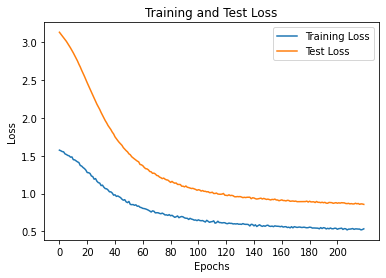

In [ ]:
# Load the training and validation loss dictionaries
train_loss_class = load(open('/content/drive/MyDrive/ML/train_loss_2_EfficientNetV2B2.pkl', 'rb'))
test_loss_class = load(open('/content/drive/MyDrive/ML/test_loss_2_EfficientNetV2B2.pkl', 'rb'))

# Retrieve each dictionary's values
train_values_class = train_loss_class.values()
test_values_class = test_loss_class.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values_class)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values_class)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

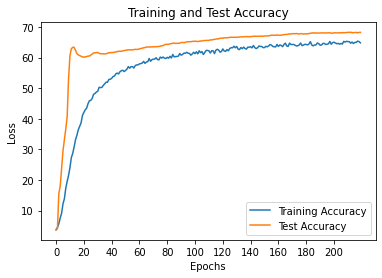

In [ ]:
# Load the training and validation loss dictionaries
train_acc = load(open('/content/drive/MyDrive/ML/train_acc_2_EfficientNetV2B2.pkl', 'rb'))
test_acc = load(open('/content/drive/MyDrive/ML/test_acc_2_EfficientNetV2B2.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_acc.values()
test_values = test_acc.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Accuracy')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Accuracy')

# Add in a title and axes labels
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filenames =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "EfficientNetV2B2_accuracy_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filenames)

classifier.save_weights(filenames)

/content/drive/MyDrive/Colab Notebooks/20230323-074745EfficientNetV2B2_accuracy_simclr.h5


In [ ]:
classifier.load_weights("/content/drive/MyDrive/Colab Notebooks/20230323-074745EfficientNetV2B2_accuracy_simclr.h5")

##Prediction

In [ ]:
X = tf.reshape(x_test[50], [1, 224, 224, 3]) ##need to reshape
classifier.predict(X)

1/1 [==============================] - 10s 10s/step


array([[1.8440590e-04, 1.0815601e-04, 3.6157004e-04, 2.7384565e-05,
        2.7257454e-04, 2.2771979e-04, 7.2719273e-04, 7.4120762e-05,
        1.8777847e-03, 1.3252412e-04, 5.5351458e-04, 2.1853421e-02,
        9.1616005e-01, 5.3665221e-02, 3.4557056e-04, 2.0236944e-04,
        5.1673100e-04, 6.3721172e-04, 6.1686977e-04, 2.1088094e-04,
        1.5122019e-04, 7.6181639e-04, 3.3172872e-04]], dtype=float32)

In [ ]:
y_predict = np.argmax(classifier.predict(x_test), axis=-1)
y_predict

67/67 [==============================] - 5s 64ms/step


array([18, 18, 11, ..., 16, 17, 12])

In [ ]:
#CONFUSIN MATRIX
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
class_names = ["cecum", "ileum", "retroflex_rectum", "hemorrhoids", "polyps","ulcerative_colitis_grade_0_1","ulcerative_colitis_grade_1","ulcerative_colitis_grade_1_2","ulcerative_colitis_grade_2","ulcerative_colitis_grade_2_3","ulcerative_colitis_grade_3","bbps_0_1" ,"bbps_2_3","impacted_stool","dyed_lifted_polyps","dyed_resection_margins","pylorus","retroflex_stomach","z_line","barretts","barretts_short_segment","esophagitis_a" ,"esophagitis_b_d"]
print(metrics.classification_report(y_test, y_predict, target_names=class_names))

                              precision    recall  f1-score   support

                       cecum       0.71      0.98      0.82       202
                       ileum       0.00      0.00      0.00         2
            retroflex_rectum       0.62      0.37      0.46        78
                 hemorrhoids       0.00      0.00      0.00         1
                      polyps       0.76      0.99      0.86       206
ulcerative_colitis_grade_0_1       0.00      0.00      0.00         7
  ulcerative_colitis_grade_1       0.00      0.00      0.00        40
ulcerative_colitis_grade_1_2       0.00      0.00      0.00         2
  ulcerative_colitis_grade_2       0.58      0.24      0.34        89
ulcerative_colitis_grade_2_3       0.00      0.00      0.00         5
  ulcerative_colitis_grade_3       0.00      0.00      0.00        27
                    bbps_0_1       0.96      0.84      0.90       129
                    bbps_2_3       0.84      1.00      0.91       230
              impac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


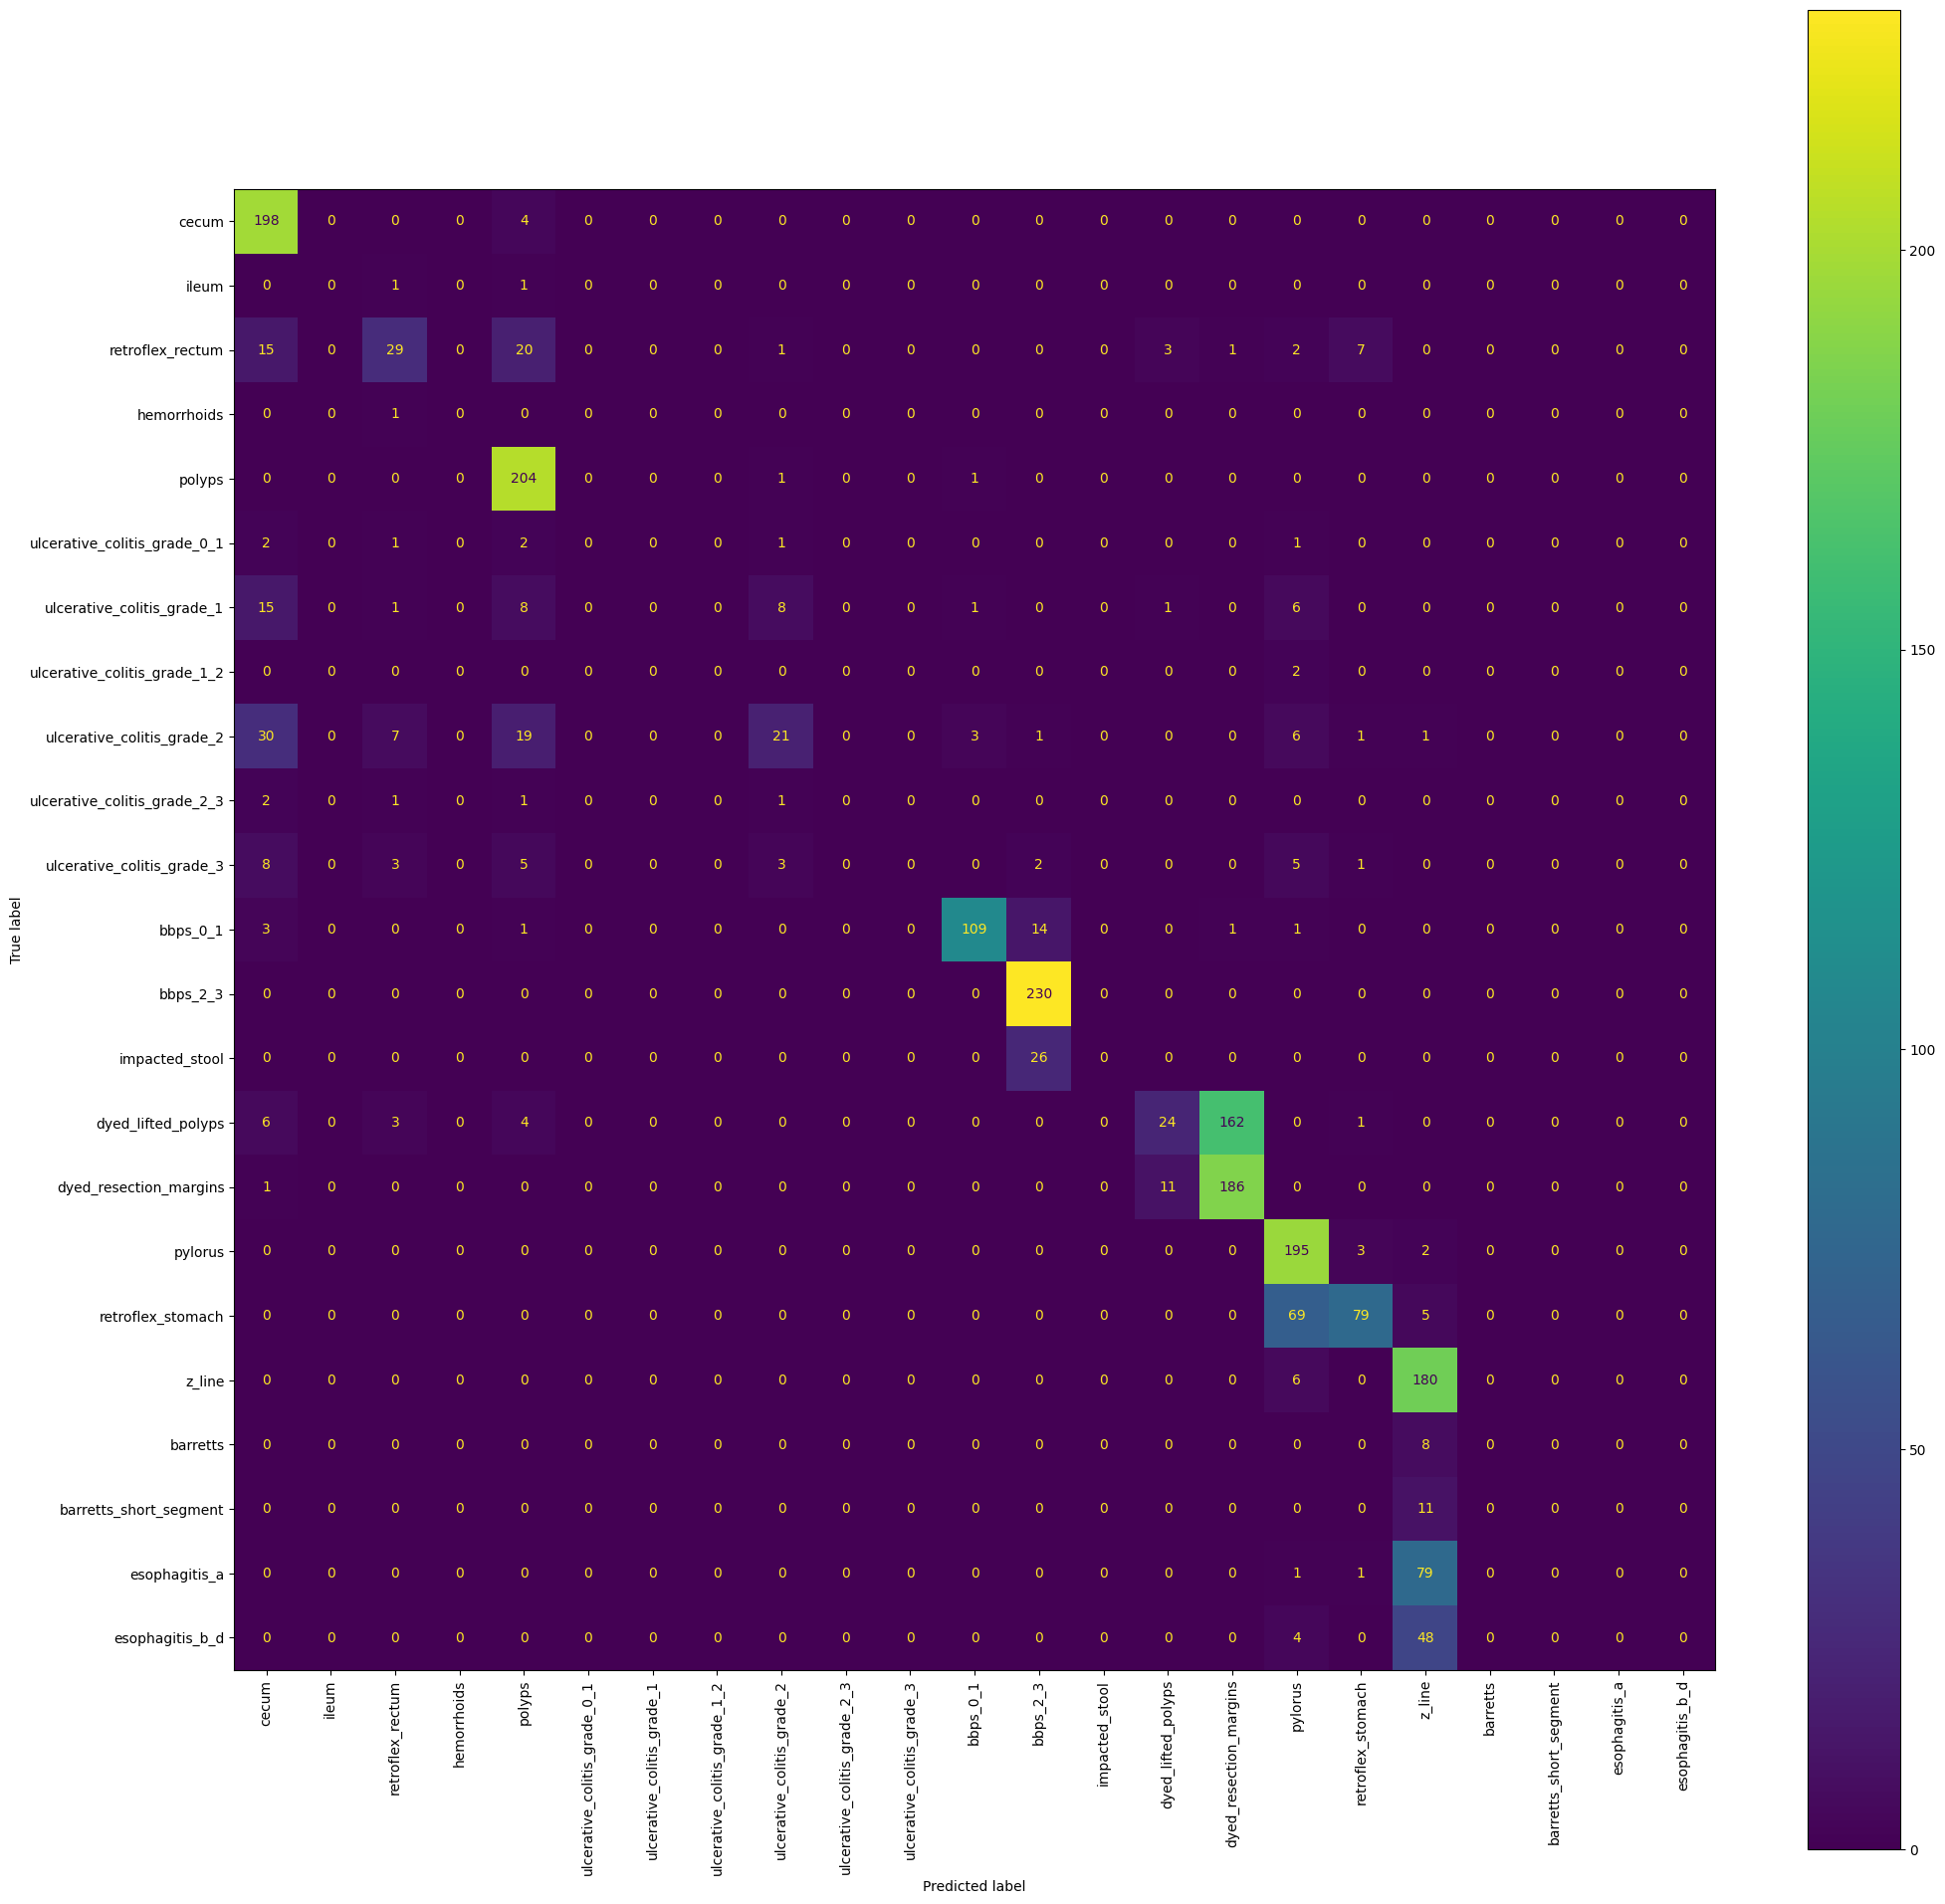

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = class_names)

plt.rcParams["figure.figsize"] = [24,24]
cm_display.plot(xticks_rotation = 'vertical')
plt.show()

In [ ]:
#check layers trainable
for i, layer in enumerate(classifier.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 input_2 [(None, 224, 224, 3)] False
1 rescaling_1 (None, 224, 224, 3) False
2 normalization_1 (None, 224, 224, 3) False
3 stem_conv (None, 112, 112, 32) False
4 stem_bn (None, 112, 112, 32) False
5 stem_activation (None, 112, 112, 32) False
6 block1a_project_conv (None, 112, 112, 16) False
7 block1a_project_bn (None, 112, 112, 16) False
8 block1a_project_activation (None, 112, 112, 16) False
9 block1b_project_conv (None, 112, 112, 16) False
10 block1b_project_bn (None, 112, 112, 16) False
11 block1b_project_activation (None, 112, 112, 16) False
12 block1b_drop (None, 112, 112, 16) False
13 block1b_add (None, 112, 112, 16) False
14 block2a_expand_conv (None, 56, 56, 64) False
15 block2a_expand_bn (None, 56, 56, 64) False
16 block2a_expand_activation (None, 56, 56, 64) False
17 block2a_project_conv (None, 56, 56, 32) False
18 block2a_project_bn (None, 56, 56, 32) False
19 block2b_expand_conv (None, 56, 56, 128) False
20 block2b_expand_bn (None, 56, 56, 128) False
21 block2b_expand_acti

#XAI

In [ ]:
##check if any error occurs here, if occurs, most likely graph not connected
def flatten_model(model):
    if not any(hasattr(layer, 'layers') for layer in model.layers):
        return model  # No sub-model defined within this model
    inputs = None
    outputs = None
    for layer in model.layers:
        if inputs is None:
            inputs = layer.input
        if hasattr(layer, 'layers'):
            submodel = layer
            last_layer = submodel.layers[-1]
            outputs = submodel.output

        if outputs is None:
            outputs = layer
        else:
            outputs = layer(outputs)
    return keras.Model(inputs=inputs, outputs=outputs)

flat_model = flatten_model(classifier)

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
X = tf.convert_to_tensor(x_test[50], dtype=tf.float32)    ##need to convert the input data to tensor
y = y_test[50].item()   ##just a single integer value, no numpy array
score = CategoricalScore(y)

In [ ]:
image_titles = ['Image']
from matplotlib import cm

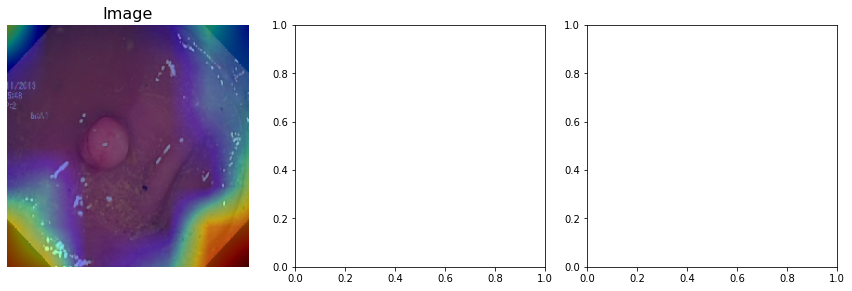

In [ ]:
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(classifier,
                  model_modifier=replace2linear,
                  clone=False)

grad_cam = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap1 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap1, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

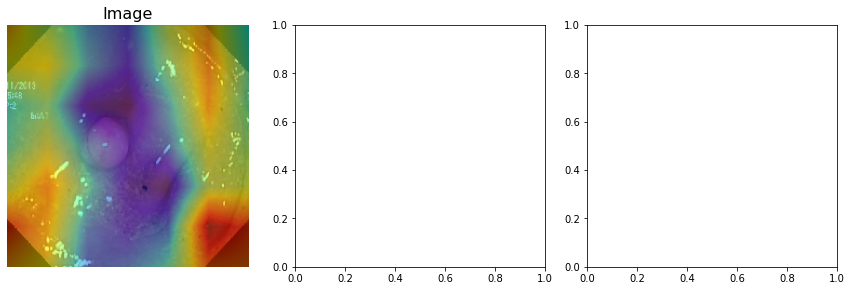

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(classifier, model_modifier=replace2linear,clone=False)

# Generate heatmap with GradCAM++
grad_cam = gradcam(score, X, penultimate_layer=-1)
# Render
#for i, title in enumerate(image_titles):
#    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap2, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with ScoreCAM
grad_cam = scorecam(score, X, penultimate_layer=-1, max_N=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap3 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap3, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 3s 3s/step


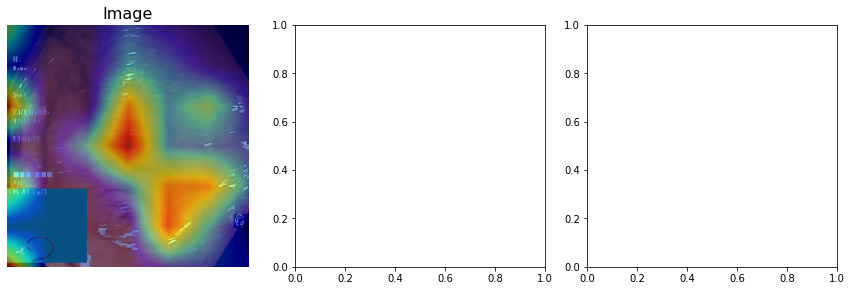

In [ ]:
# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with Faster-ScoreCAM
grad_cam = scorecam(score,X,penultimate_layer=-1,max_N=10)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap4 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap4, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

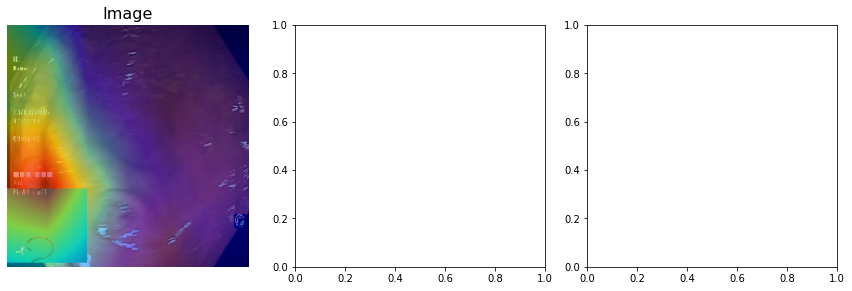

In [ ]:
from tf_keras_vis.layercam import Layercam

layercam = Layercam(classifier, model_modifier=replace2linear,clone = False)

# Generate heatmap with Faster-ScoreCAM
grad_cam = layercam(score,X,penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap5 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap5, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

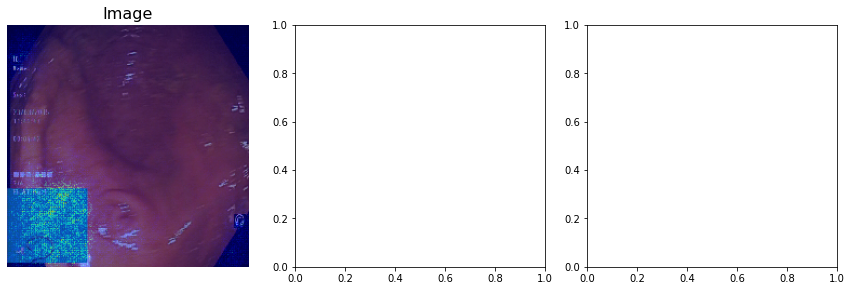

In [ ]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(classifier, model_modifier=replace2linear,clone=False)

# Generate saliency map
saliency_map_van = saliency(score, X)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap6 = np.uint8(cm.jet(saliency_map_van[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap6, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

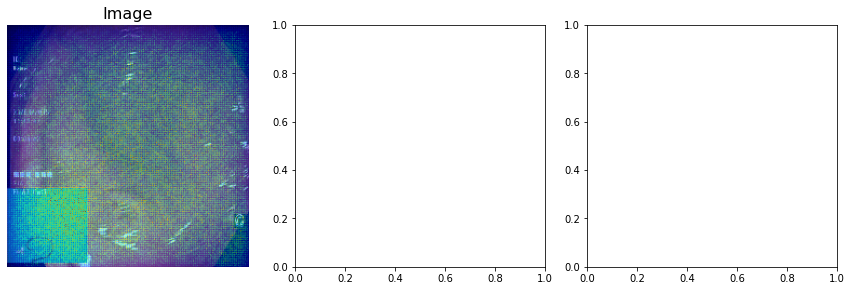

In [ ]:
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map_smooth = saliency(score,X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap7 = np.uint8(cm.jet(saliency_map_smooth[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap7, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

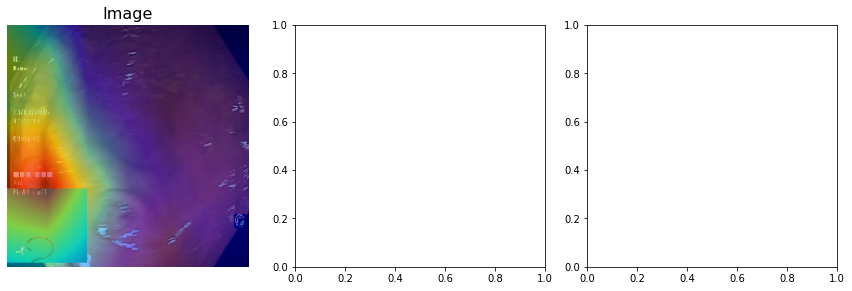

In [ ]:
# Render
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

ax[0][0].set_title("Original", fontsize=12)
ax[0][0].imshow(x_test[50])
ax[0][0].axis('off')

ax[0][1].set_title("GradCAM", fontsize=12)
ax[0][1].imshow(x_test[50])
ax[0][1].imshow(heatmap1, cmap='jet', alpha=0.5)
ax[0][1].axis('off')

ax[0][2].set_title("GradCAM++", fontsize=12)
ax[0][2].imshow(x_test[50])
ax[0][2].imshow(heatmap2, cmap='jet', alpha=0.5)
ax[0][2].axis('off')

ax[0][3].set_title("ScoreCAM", fontsize=12)
ax[0][3].imshow(x_test[50])
ax[0][3].imshow(heatmap3, cmap='jet', alpha=0.5)
ax[0][3].axis('off')

ax[1][0].set_title("ScoreCAM++", fontsize=12)
ax[1][0].imshow(x_test[50])
ax[1][0].imshow(heatmap4, cmap='jet', alpha=0.5)
ax[1][0].axis('off')

ax[1][1].set_title("LayerCAM", fontsize=12)
ax[1][1].imshow(x_test[50])
ax[1][1].imshow(heatmap5, cmap='jet', alpha=0.5)
ax[1][1].axis('off')

ax[1][2].set_title("Vanilla Saliency", fontsize=12)
ax[1][2].imshow(saliency_map_van[0], cmap='jet')
ax[1][2].axis('off')

ax[1][3].set_title("Smooth Grad", fontsize=12)
ax[1][3].imshow(saliency_map_smooth[0], cmap='jet')
ax[1][3].axis('off')

plt.show()